In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 77
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Define Model

In [5]:
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.4 MB/s eta 0:00:00


## Hyper Parameters

In [6]:
lr= 1e-4
epochs = 100
batch_size = 16


## Data Loader

In [7]:
train_transform = A.Compose(
    [
        A.RandomCrop(384, 384),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.1),

        A.OneOf([
            # A.ElasticTransform(p=1),
            A.OpticalDistortion(p=1),
            A.GridDistortion(p=1),
        ], p=0.1),
        A.Normalize(),
        ToTensorV2()
    ]
)
test_transform = A.Compose(
    [
        A.CenterCrop(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/AI_proj/data/train', transform=train_transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [8]:
# dataset_size =  len(train_dataset)
# subset_size = int(0.1 * dataset_size )
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# subset_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [9]:
test_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/AI_proj/data/test', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=12)

# dataset_size =  len(test_dataset)
# # 10%의 Random dataset 데이터셋 생성
# subset_size = int(1.0 * dataset_size)
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# mini_test = Subset(test_dataset, subset_indices)
# mini_test_loader = DataLoader(mini_test, batch_size, shuffle=True, num_workers=16)

## Model Train

In [10]:
# model 초기화
from backbones_unet.model.unet import Unet
model = Unet(
    backbone='convnext_small',
    in_channels=3,
    num_classes=1,
).to(device=device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
# train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(test_dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(test_dataloader))
    if epoch % 50 == 0:
      torch.save(model.state_dict(), f'./model{epoch}.pt')


    print(f'\nEpoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(test_dataloader)}')



Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_1k_224_ema.pth
100%|██████████| 36/36 [01:38<00:00,  2.73s/it]



Epoch 1, Loss: 0.5903359860595729, Test Loss : 0.46093086236053044


100%|██████████| 36/36 [00:06<00:00,  5.44it/s]



Epoch 2, Loss: 0.39519864072402316, Test Loss : 0.4109302966131104


100%|██████████| 36/36 [00:06<00:00,  5.77it/s]



Epoch 3, Loss: 0.35758773506515557, Test Loss : 0.35716258320543504


100%|██████████| 36/36 [00:06<00:00,  5.36it/s]



Epoch 4, Loss: 0.329578351850311, Test Loss : 0.32825884305768543


100%|██████████| 36/36 [00:06<00:00,  5.83it/s]



Epoch 5, Loss: 0.3083643491069476, Test Loss : 0.30567098947034943


100%|██████████| 36/36 [00:06<00:00,  5.46it/s]



Epoch 6, Loss: 0.28897444738282096, Test Loss : 0.2882925404442681


100%|██████████| 36/36 [00:06<00:00,  5.81it/s]



Epoch 7, Loss: 0.2705239497332109, Test Loss : 0.2730550020933151


100%|██████████| 36/36 [00:06<00:00,  5.38it/s]



Epoch 8, Loss: 0.25390603196703726, Test Loss : 0.24617780620853105


100%|██████████| 36/36 [00:06<00:00,  5.75it/s]



Epoch 9, Loss: 0.2385490419757035, Test Loss : 0.23661227317319977


100%|██████████| 36/36 [00:06<00:00,  5.46it/s]



Epoch 10, Loss: 0.22519823474188647, Test Loss : 0.22678790241479874


100%|██████████| 36/36 [00:06<00:00,  5.67it/s]



Epoch 11, Loss: 0.20954965479258034, Test Loss : 0.21526627325349385


100%|██████████| 36/36 [00:06<00:00,  5.71it/s]



Epoch 12, Loss: 0.20007214850435653, Test Loss : 0.21418867198129496


100%|██████████| 36/36 [00:06<00:00,  5.43it/s]



Epoch 13, Loss: 0.18971978096912304, Test Loss : 0.19288232343064415


100%|██████████| 36/36 [00:06<00:00,  5.74it/s]



Epoch 14, Loss: 0.18176475260406733, Test Loss : 0.189704991877079


100%|██████████| 36/36 [00:06<00:00,  5.37it/s]



Epoch 15, Loss: 0.17097385962390238, Test Loss : 0.17799054148296514


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]



Epoch 16, Loss: 0.16381304876671898, Test Loss : 0.17724977682034174


100%|██████████| 36/36 [00:06<00:00,  5.37it/s]



Epoch 17, Loss: 0.1554735851370626, Test Loss : 0.17057323849035633


100%|██████████| 36/36 [00:06<00:00,  5.79it/s]



Epoch 18, Loss: 0.14731947048049834, Test Loss : 0.15594120509922504


100%|██████████| 36/36 [00:06<00:00,  5.44it/s]



Epoch 19, Loss: 0.14124177613606057, Test Loss : 0.1527263978496194


100%|██████████| 36/36 [00:06<00:00,  5.79it/s]



Epoch 20, Loss: 0.13644445434005725, Test Loss : 0.15126782024486196


100%|██████████| 36/36 [00:06<00:00,  5.51it/s]



Epoch 21, Loss: 0.13287197477701637, Test Loss : 0.14550569374114275


100%|██████████| 36/36 [00:06<00:00,  5.81it/s]



Epoch 22, Loss: 0.12751053703121012, Test Loss : 0.13476292230188847


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 23, Loss: 0.12278899043384525, Test Loss : 0.13405091346551976


100%|██████████| 36/36 [00:06<00:00,  5.51it/s]



Epoch 24, Loss: 0.12081219255924225, Test Loss : 0.1335487767226166


100%|██████████| 36/36 [00:06<00:00,  5.69it/s]



Epoch 25, Loss: 0.11678248105777635, Test Loss : 0.12929167546745804


100%|██████████| 36/36 [00:06<00:00,  5.41it/s]



Epoch 26, Loss: 0.11722525892158349, Test Loss : 0.13017515879538324


100%|██████████| 36/36 [00:06<00:00,  5.72it/s]



Epoch 27, Loss: 0.11220280655349295, Test Loss : 0.12774227807919183


100%|██████████| 36/36 [00:06<00:00,  5.36it/s]



Epoch 28, Loss: 0.10818193759769201, Test Loss : 0.1195439749604298


100%|██████████| 36/36 [00:06<00:00,  5.76it/s]



Epoch 29, Loss: 0.10594573829116093, Test Loss : 0.12148951713202728


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]



Epoch 30, Loss: 0.10287565851791038, Test Loss : 0.11775457688296835


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 31, Loss: 0.09914281529684861, Test Loss : 0.11588648297927445


100%|██████████| 36/36 [00:06<00:00,  5.64it/s]



Epoch 32, Loss: 0.09891732983912031, Test Loss : 0.1150080116155247


100%|██████████| 36/36 [00:06<00:00,  5.50it/s]



Epoch 33, Loss: 0.09803334835709797, Test Loss : 0.11577342424748673


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 34, Loss: 0.09837532793689105, Test Loss : 0.11190659045759174


100%|██████████| 36/36 [00:06<00:00,  5.36it/s]



Epoch 35, Loss: 0.09557525560052858, Test Loss : 0.11090436707147294


100%|██████████| 36/36 [00:06<00:00,  5.78it/s]



Epoch 36, Loss: 0.09430323735189934, Test Loss : 0.11117933307670885


100%|██████████| 36/36 [00:06<00:00,  5.35it/s]



Epoch 37, Loss: 0.09480437491503027, Test Loss : 0.11282673152163625


100%|██████████| 36/36 [00:06<00:00,  5.71it/s]



Epoch 38, Loss: 0.09051162734006842, Test Loss : 0.1125781205482781


100%|██████████| 36/36 [00:06<00:00,  5.37it/s]



Epoch 39, Loss: 0.08935769675816926, Test Loss : 0.11024661284560959


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 40, Loss: 0.09113560585925977, Test Loss : 0.1088333267511593


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]



Epoch 41, Loss: 0.08814454306330946, Test Loss : 0.10903700896435314


100%|██████████| 36/36 [00:06<00:00,  5.51it/s]



Epoch 42, Loss: 0.088391808896429, Test Loss : 0.10720002107943098


100%|██████████| 36/36 [00:06<00:00,  5.74it/s]



Epoch 43, Loss: 0.08568159151925808, Test Loss : 0.10593512801763912


100%|██████████| 36/36 [00:06<00:00,  5.36it/s]



Epoch 44, Loss: 0.08482947001337177, Test Loss : 0.10583628432100846


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]



Epoch 45, Loss: 0.08602401632298198, Test Loss : 0.10445958321603636


100%|██████████| 36/36 [00:06<00:00,  5.35it/s]



Epoch 46, Loss: 0.08421215458980037, Test Loss : 0.11603319166331655


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 47, Loss: 0.08235458072481884, Test Loss : 0.10343473603845471


100%|██████████| 36/36 [00:06<00:00,  5.53it/s]



Epoch 48, Loss: 0.08132265107188788, Test Loss : 0.1036676842874537


100%|██████████| 36/36 [00:06<00:00,  5.59it/s]



Epoch 49, Loss: 0.08202035404327843, Test Loss : 0.10418300025372042


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 50, Loss: 0.08213659838980271, Test Loss : 0.10286555490973923


100%|██████████| 36/36 [00:06<00:00,  5.37it/s]



Epoch 51, Loss: 0.08358329544878668, Test Loss : 0.10301931435242295


100%|██████████| 36/36 [00:06<00:00,  5.71it/s]



Epoch 52, Loss: 0.08072733480690254, Test Loss : 0.1051240670753436


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]



Epoch 53, Loss: 0.07904672883968386, Test Loss : 0.10445493832230568


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]



Epoch 54, Loss: 0.0794315740155677, Test Loss : 0.10843385704275635


100%|██████████| 36/36 [00:06<00:00,  5.44it/s]



Epoch 55, Loss: 0.08441947686434206, Test Loss : 0.10622534807771444


100%|██████████| 36/36 [00:06<00:00,  5.51it/s]



Epoch 56, Loss: 0.07665673785635994, Test Loss : 0.10549930977221164


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 57, Loss: 0.07656528808486958, Test Loss : 0.104197406830887


100%|██████████| 36/36 [00:07<00:00,  5.14it/s]



Epoch 58, Loss: 0.0757955495112886, Test Loss : 0.10611320620713134


100%|██████████| 36/36 [00:06<00:00,  5.74it/s]



Epoch 59, Loss: 0.07732135664102519, Test Loss : 0.10508444483598901


100%|██████████| 36/36 [00:06<00:00,  5.31it/s]



Epoch 60, Loss: 0.07633581739436421, Test Loss : 0.10356967787568767


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]



Epoch 61, Loss: 0.07543868274014029, Test Loss : 0.10662101573931675


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]



Epoch 62, Loss: 0.07657219541983472, Test Loss : 0.10198847639063995


100%|██████████| 36/36 [00:06<00:00,  5.72it/s]



Epoch 63, Loss: 0.0747175225470629, Test Loss : 0.10178640114867853


100%|██████████| 36/36 [00:06<00:00,  5.64it/s]



Epoch 64, Loss: 0.07451104036428863, Test Loss : 0.10342688369564712


100%|██████████| 36/36 [00:06<00:00,  5.44it/s]



Epoch 65, Loss: 0.07490707786443333, Test Loss : 0.1054066045778907


100%|██████████| 36/36 [00:06<00:00,  5.67it/s]



Epoch 66, Loss: 0.07459203852340579, Test Loss : 0.10172694564486544


100%|██████████| 36/36 [00:06<00:00,  5.34it/s]



Epoch 67, Loss: 0.07570951237964134, Test Loss : 0.1037178868945274


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]



Epoch 68, Loss: 0.0738154951379531, Test Loss : 0.10263366469492514


100%|██████████| 36/36 [00:06<00:00,  5.30it/s]



Epoch 69, Loss: 0.07455504094509201, Test Loss : 0.10016780085344282


100%|██████████| 36/36 [00:06<00:00,  5.72it/s]



Epoch 70, Loss: 0.07288743859519148, Test Loss : 0.10449083806532952


100%|██████████| 36/36 [00:06<00:00,  5.53it/s]



Epoch 71, Loss: 0.07429501119380195, Test Loss : 0.1011978706293222


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]



Epoch 72, Loss: 0.07202651105924612, Test Loss : 0.10227405153111452


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 73, Loss: 0.07256897467757678, Test Loss : 0.10382338618445727


100%|██████████| 36/36 [00:06<00:00,  5.40it/s]



Epoch 74, Loss: 0.0726231088111591, Test Loss : 0.10493046097043487


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]



Epoch 75, Loss: 0.0717097851447761, Test Loss : 0.10194061810357703


100%|██████████| 36/36 [00:06<00:00,  5.37it/s]



Epoch 76, Loss: 0.07103861428590284, Test Loss : 0.10496182998435365


100%|██████████| 36/36 [00:06<00:00,  5.73it/s]



Epoch 77, Loss: 0.07238834271103972, Test Loss : 0.10292459719089998


100%|██████████| 36/36 [00:06<00:00,  5.45it/s]



Epoch 78, Loss: 0.06868206524652326, Test Loss : 0.10350176532908033


100%|██████████| 36/36 [00:06<00:00,  5.73it/s]



Epoch 79, Loss: 0.06997251800364918, Test Loss : 0.10017670847527269


100%|██████████| 36/36 [00:06<00:00,  5.58it/s]



Epoch 80, Loss: 0.06917046637843466, Test Loss : 0.1012511868805935


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 81, Loss: 0.06898532448233002, Test Loss : 0.10284037890637086


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 82, Loss: 0.0689544601417664, Test Loss : 0.10363460955623952


100%|██████████| 36/36 [00:06<00:00,  5.36it/s]



Epoch 83, Loss: 0.06835026230611321, Test Loss : 0.10135302552953362


100%|██████████| 36/36 [00:06<00:00,  5.71it/s]



Epoch 84, Loss: 0.06927746522706002, Test Loss : 0.10458062061419089


100%|██████████| 36/36 [00:06<00:00,  5.33it/s]



Epoch 85, Loss: 0.06891651727103938, Test Loss : 0.10140453377324674


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 86, Loss: 0.06738637361882462, Test Loss : 0.10325451844578816


100%|██████████| 36/36 [00:06<00:00,  5.58it/s]



Epoch 87, Loss: 0.06889469345979807, Test Loss : 0.10009341186378151


100%|██████████| 36/36 [00:06<00:00,  5.52it/s]



Epoch 88, Loss: 0.06766617674535762, Test Loss : 0.10447949521605754


100%|██████████| 36/36 [00:06<00:00,  5.68it/s]



Epoch 89, Loss: 0.06710422264101605, Test Loss : 0.09995760266772574


100%|██████████| 36/36 [00:06<00:00,  5.31it/s]



Epoch 90, Loss: 0.06755859177145693, Test Loss : 0.103350138084756


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 91, Loss: 0.06933547939277357, Test Loss : 0.10239302837807271


100%|██████████| 36/36 [00:06<00:00,  5.28it/s]



Epoch 92, Loss: 0.06852223836661626, Test Loss : 0.101799344475795


100%|██████████| 36/36 [00:06<00:00,  5.73it/s]



Epoch 93, Loss: 0.06499214506604606, Test Loss : 0.10282634219361676


100%|██████████| 36/36 [00:06<00:00,  5.57it/s]



Epoch 94, Loss: 0.06575825802671413, Test Loss : 0.10212656811604069


100%|██████████| 36/36 [00:06<00:00,  5.49it/s]



Epoch 95, Loss: 0.06563268885171662, Test Loss : 0.10038291952676243


100%|██████████| 36/36 [00:06<00:00,  5.85it/s]



Epoch 96, Loss: 0.06414805176771349, Test Loss : 0.1026991141649584


100%|██████████| 36/36 [00:06<00:00,  5.38it/s]



Epoch 97, Loss: 0.06702356066347824, Test Loss : 0.10406429682754809


100%|██████████| 36/36 [00:06<00:00,  5.69it/s]



Epoch 98, Loss: 0.0662515679270857, Test Loss : 0.10383319223506583


100%|██████████| 36/36 [00:06<00:00,  5.37it/s]



Epoch 99, Loss: 0.06733258585962984, Test Loss : 0.10898671838610123


100%|██████████| 36/36 [00:06<00:00,  5.72it/s]


Epoch 100, Loss: 0.06774435333338463, Test Loss : 0.1021568398638111


In [11]:
torch.save(model.state_dict(), './eff_m.pt')

## Epoch에 따른 Loss 변화

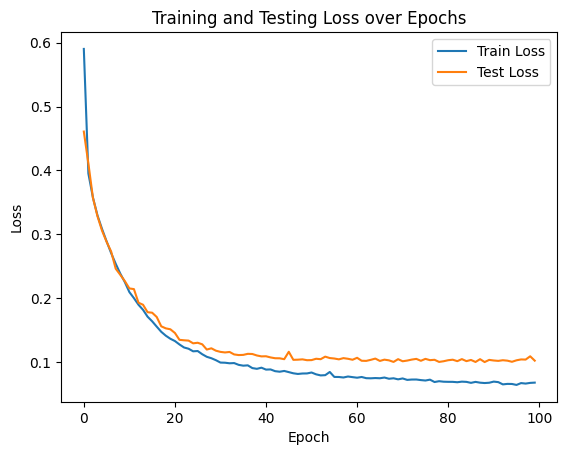

In [12]:

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

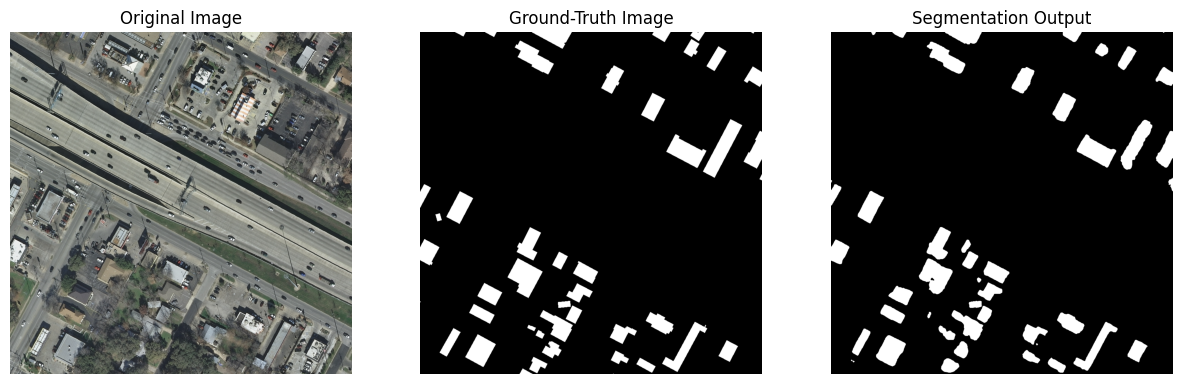

In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 모델 인스턴스 생성 및 가중치 로드
model_trained = model # Unet
# model_trained = Unet_resnet.to(device) # Unet + Resnet
# model_trained.load_state_dict(torch.load('./model.pt')) # 가중치파일 경로
model_trained.eval() # 평가 모드로 설정

# 이미지 전처리
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ])
    input_tensor = preprocess(image=np.array(input_image))['image']
    input_batch = input_tensor.unsqueeze(0) # 배치 차원 추가
    return input_batch

# 이미지 경로
image_path = '/content/drive/MyDrive/AI_proj/inria/cropped_1024/austin1/images/austin1_0_0.jpg'
gt_path = '/content/drive/MyDrive/AI_proj/inria/cropped_1024/austin1/binary_masks/austin1_0_0.tif'

# 이미지 전처리 및 예측 수행
with torch.no_grad():
    input_batch = preprocess_image(image_path)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_trained.to('cuda')

    output = model_trained(input_batch)

# 결과 처리
output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() # Sigmoid 적용 및 이미지 형태로 변환
output = (output > 0.5).astype(np.uint8) # Threshold 적용

# 원본 이미지 보기
plt.figure(figsize=(15, 5))  # 전체 그림의 크기를 늘림

original_image = Image.open(image_path)
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")

# ground truth 이미지 보기
gt_image = Image.open(gt_path)
plt.subplot(1, 3, 2)
plt.imshow(gt_image)
plt.axis('off')
plt.title("Ground-Truth Image")

# 결과 이미지 보기 (Matplotlib 사용)
plt.subplot(1, 3, 3)
plt.imshow(output, cmap='gray')  # 'gray'는 흑백 이미지인 경우 사용
plt.axis('off')  # 축 제거
plt.title("Segmentation Output")

plt.show()


In [14]:
# model = Unet_resnet.to(device) # Unet + Resnet
# model.load_state_dict(torch.load('./model50.pt')) # 가중치파일 경로
model.eval() # 평가 모드로 설정

all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(test_dataloader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images)

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
# precision = precision_score(true_masks_flat, predicted_masks_flat)
# recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



100%|██████████| 36/36 [00:06<00:00,  5.55it/s]


IoU: 0.7904409957233218
Dice Coefficient: 0.8829567660831971
